# MTHE 472 Computational Project
##### Oscar Brown - 20236037 - 12 April 2024

In [134]:
import numpy as np
from scipy.optimize import linprog
from scipy.integrate import quad
import matplotlib.pyplot as plt
from IPython.display import Image
import random
import itertools

---

### **Q1: Value Iteration/Policy Iteration/ Q-Learning/ Convex Analytic Method/ Quantized Q-Learning**

In [135]:
# define all globals for 1

# hyperparameter values
states = {'B', 'G'}
actions = {0, 1}
beta = 0.5
etas = [0.9, 0.7, 0.01]

# transtion kernel probabilities 
def transition_kernel(next_state, current_state, u):
    if (next_state == 'G'):
        if (current_state == 'G'):
            if (u == 1):
                return 0.1
            elif (u == 0):
                return 0.9
        elif (current_state == 'B'):
            if (u == 1):
                return 0.8
            elif (u == 0):
                return 0.5
    elif (next_state == 'B'):
        if (current_state == 'G'):
            if (u == 1):
                return 0.9
            elif (u == 0):
                return 0.1
        elif (current_state == 'B'):
            if (u == 1):
                return 0.2
            elif (u == 0):
                return 0.5

# cost function
def cost(x, u, eta):
    if x == 'G' and u == 1:
        return -1 + eta * u
    else:
        return eta * u

### a)
#### (i) Value iteration

In [136]:
# value iteration function
def value_iteration(eta, beta, states, actions, transition_kernel, num_iterations=10000):
    V = {current_state: 0 for current_state in states}
    
    # iteration algorithm
    for _ in range(num_iterations):
        V_new = {}
        for current_state in states:
            V_new[current_state] = min([cost(current_state, a, eta) + beta * sum([transition_kernel(next_state, current_state, a) * V[next_state] for next_state in states]) for a in actions])
        V = V_new
        
    # Derive the optimal policy via value iteration
    policy = {}
    for current_state in states:
        policy[current_state] = np.argmin([cost(current_state, a, eta) + beta * sum([transition_kernel(next_state, current_state, a) * V[next_state] for next_state in states]) for a in actions])

    # return optimal cost and optimal policy
    return V, policy

for eta in etas:
    V, policy = value_iteration(eta, beta, states, actions, transition_kernel)
    print(f"Results for η = {eta}:")
    print(f"Optimal Cost: {V}")
    print(f"Optimal Policy: {policy}")
    print()

Results for η = 0.9:
Optimal Cost: {'B': -0.04166666666666666, 'G': -0.12499999999999997}
Optimal Policy: {'B': 0, 'G': 1}

Results for η = 0.7:
Optimal Cost: {'B': -0.125, 'G': -0.37500000000000006}
Optimal Policy: {'B': 0, 'G': 1}

Results for η = 0.01:
Optimal Cost: {'B': -0.5725925925925925, 'G': -1.3133333333333332}
Optimal Policy: {'B': 1, 'G': 1}



#### (ii) Policy iteration

In [137]:
# policy evaluation function
def policy_evaluation(policy, eta, beta, states, actions, transition_kernel, num_iterations=10000):
    V = {current_state: 0 for current_state in states}
    
    # iterative evaluation algorithm
    for _ in range(num_iterations):
        V_new = {}
        
        # compute optimal cost
        for current_state in states:
            a = policy[current_state]
            V_new[current_state] = cost(current_state, a, eta) + beta * sum([transition_kernel(next_state, current_state, a) * V[next_state] for next_state in states])
        V = V_new
        
    # return optimal cost
    return V

# policy iteration function
def policy_iteration(eta, beta, states, actions, transition_kernel, num_iterations=10000):
    policy = {current_state: 0 for current_state in states}
    
    # iteration algorithm 
    for _ in range(num_iterations):
        V = policy_evaluation(policy, eta, beta, states, actions, transition_kernel)
        policy_stable = True
        
        # compute optimal policy
        for current_state in states:
            old_action = policy[current_state]
            policy[current_state] = np.argmin([cost(current_state, a, eta) + beta * sum([transition_kernel(next_state, current_state, a) * V[next_state] for next_state in states]) for a in actions])
            if old_action != policy[current_state]:
                policy_stable = False
        if policy_stable:
            break
    
    # return optimal policy and optimal cost
    return V, policy

for eta in etas:
    V, policy = policy_iteration(eta, beta, states, actions, transition_kernel)
    print(f"Results for η = {eta}:")
    print(f"Optimal Cost: {V}")
    print(f"Optimal Policy: {policy}")
    print()

Results for η = 0.9:
Optimal Cost: {'B': -0.04166666666666666, 'G': -0.12499999999999997}
Optimal Policy: {'B': 0, 'G': 1}

Results for η = 0.7:
Optimal Cost: {'B': -0.125, 'G': -0.37500000000000006}
Optimal Policy: {'B': 0, 'G': 1}

Results for η = 0.01:
Optimal Cost: {'B': -0.5725925925925925, 'G': -1.3133333333333332}
Optimal Policy: {'B': 1, 'G': 1}



#### (iii) Q-learning

In [138]:
# calculate coefficients function
def calc_alpha(state, action, history):
    total = 1
    for item in history:
        if item == [state, action]:
            total += 1
    return 1 / total

# Q-learnign function
def perform_q_learning(state_space, action_space, trans_kernel, cost_fn, eta_val, discount_factor, num_iterations=10000):
    state_mapping = {state: idx for idx, state in enumerate(state_space)}
    action_mapping = {action: idx for idx, action in enumerate(action_space)}
    Q_table = np.zeros((len(state_space), len(action_space)))
    # begin from random state 
    current_st = np.random.choice(list(state_space))
    hist = []

    # Q-learning algorithm
    for _ in range(num_iterations):
        state_idx = state_mapping[current_st]
        # control input is either random or selected via Q-optimal policy
        if np.random.rand() < 0.1:
            selected_action = np.random.choice(list(action_space))
        else:
            selected_action = np.argmin(Q_table[state_idx, :])
        # probabilistic transition to next state 
        action_idx = action_mapping[selected_action]
        hist.append([current_st, selected_action])
        next_st_prob = [trans_kernel(next_st, current_st, selected_action) for next_st in state_space]
        next_st = np.random.choice(list(state_space), p=next_st_prob)
        next_state_idx = state_mapping[next_st]
        # update the Q-table
        Q_table[state_idx, action_idx] += calc_alpha(current_st, selected_action, hist) * (
            cost_fn(current_st, selected_action, eta_val) + discount_factor * np.min(Q_table[next_state_idx, :]) - Q_table[state_idx, action_idx]
        )

        current_st = next_st

    # use Q-table to compute optimal policy and optimal cost
    optimal_policy = {state: list(action_space)[np.argmin(Q_table[state_mapping[state], :])] for state in state_space}
    optimal_cost = {state: Q_table[state_mapping[state], np.argmin(Q_table[state_mapping[state], :])] for state in state_space}
    
    # return optimal policy and optimal cost
    return optimal_policy, optimal_cost

optimal_policy, optimal_cost = perform_q_learning(states, actions, transition_kernel, cost, 0.7, 0.1)
print("Optimal Cost:", optimal_cost)
print("Optimal Policy:", optimal_policy)

Optimal Cost: {'B': -0.01609719295466383, 'G': -0.3043493531253564}
Optimal Policy: {'B': 0, 'G': 1}


For all values of eta, both value iteration and policy iteration converge to the same optimal policy and otptimal costs. 
For eta = 0.7, value iteration, policy iteration, and Q-learning converge to the same optimal policy and optimal costs.

### b)

In [139]:
# define transition kernel in context of new problem 
def transition_kernel_q(bounds, x, u):
    lower_bound, upper_bound = bounds
    if u == 1:
        integrand = lambda z: 2 * (1 - z) if lower_bound <= z <= upper_bound else 0
    else:  
        integrand = lambda z: 2 * z if lower_bound <= z <= upper_bound else 0
    result, _ = quad(integrand, lower_bound, upper_bound)
    return result

# define cost function in context of new problem 
def cost(x, u, eta):
    return -x * u + eta * u

def quantize_state_space(num_states):
    return np.linspace(0, 1, num_states + 1)[:-1]

# Q-learning funciton
def perform_q_learning(state_space, action_space, trans_kernel, cost_fn, eta_val, discount_factor, num_iterations=1000):
    state_mapping = {state: idx for idx, state in enumerate(state_space)}
    num_states = len(state_space)
    num_actions = len(action_space)
    Q = np.zeros((num_states, num_actions))
    
    # Q-learning algorithm 
    for _ in range(num_iterations):
        current_st = np.random.choice(state_space)
        current_state_idx = state_mapping[current_st]
        selected_action = np.argmax(Q[current_state_idx])
        bounds = [(current_st, current_st + 1/num_states) for current_st in state_space]
        next_st_prob = [trans_kernel(bounds[state_mapping[current_st]], current_st, selected_action) for current_st in state_space]
        next_st_prob = np.array(next_st_prob)
        next_st_prob /= next_st_prob.sum()
        next_st = np.random.choice(state_space, p=next_st_prob)
        next_state_idx = state_mapping[next_st]
        Q[current_state_idx, selected_action] += eta_val * (cost_fn(current_st, selected_action) + discount_factor * np.min(Q[next_state_idx]) - Q[current_state_idx, selected_action])
    
    # use Q-table to compute optimal policy and optimal cost
    optimal_policy = {state: action_space[np.argmin(Q[state_mapping[state]])] for state in state_space}
    optimal_cost = {state: np.min(Q[state_mapping[state]]) for state in state_space}
    
    # return optimal policy and optimal cost
    return optimal_policy, optimal_cost

granularity_levels = [10, 20, 50, 100]

for n in granularity_levels:
    state_space = quantize_state_space(n)
    actions = [0, 1]
    cost_fn = lambda x, u: cost(x, u, 0.7) 
    optimal_policy, optimal_cost = perform_q_learning(state_space, actions, transition_kernel_q, cost_fn, 0.7, 0.1)
    print(f"Granularity Level: {n}")
    print("Optimal Cost:", optimal_cost)
    print("Optimal Policy:", optimal_policy)

Granularity Level: 10
Optimal Cost: {0.0: 0.0, 0.1: 0.0, 0.2: 0.0, 0.30000000000000004: 0.0, 0.4: 0.0, 0.5: 0.0, 0.6000000000000001: 0.0, 0.7000000000000001: 0.0, 0.8: 0.0, 0.9: 0.0}
Optimal Policy: {0.0: 0, 0.1: 0, 0.2: 0, 0.30000000000000004: 0, 0.4: 0, 0.5: 0, 0.6000000000000001: 0, 0.7000000000000001: 0, 0.8: 0, 0.9: 0}
Granularity Level: 20
Optimal Cost: {0.0: 0.0, 0.05: 0.0, 0.1: 0.0, 0.15000000000000002: 0.0, 0.2: 0.0, 0.25: 0.0, 0.30000000000000004: 0.0, 0.35000000000000003: 0.0, 0.4: 0.0, 0.45: 0.0, 0.5: 0.0, 0.55: 0.0, 0.6000000000000001: 0.0, 0.65: 0.0, 0.7000000000000001: 0.0, 0.75: 0.0, 0.8: 0.0, 0.8500000000000001: 0.0, 0.9: 0.0, 0.9500000000000001: 0.0}
Optimal Policy: {0.0: 0, 0.05: 0, 0.1: 0, 0.15000000000000002: 0, 0.2: 0, 0.25: 0, 0.30000000000000004: 0, 0.35000000000000003: 0, 0.4: 0, 0.45: 0, 0.5: 0, 0.55: 0, 0.6000000000000001: 0, 0.65: 0, 0.7000000000000001: 0, 0.75: 0, 0.8: 0, 0.8500000000000001: 0, 0.9: 0, 0.9500000000000001: 0}
Granularity Level: 50
Optimal Co

### c)

In [140]:
class FadingChannelQlearning:
    def __init__(self, eta, alpha=0.1, beta=0.95, epsilon=0.1, num_episodes=1000, max_steps=100):
        self.eta = eta
        self.alpha = alpha
        self.beta = beta
        self.epsilon = epsilon
        self.num_episodes = num_episodes
        self.max_steps = max_steps
        self.Q = np.zeros((2, 2))
        
        self.transitions = {
            (0, 0): [1, 0],  # Stys in good state with do nothing
            (0, 1): [0.1, 0.9],  # Moves to bad state with high probability when using
            (1, 0): [0.5, 0.5],  # Has a chance to recover or stay down with do nothing
            (1, 1): [1, 0],  # Stays down when attempting repair, this might need adjusting based on the scenario's logic
        }

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice([0, 1])
        else:
            return np.argmax(self.Q[state])

    def update_q(self, state, action, reward, next_state):
        future_rewards = np.max(self.Q[next_state])
        self.Q[state, action] += self.alpha * (reward + self.beta * future_rewards - self.Q[state, action])

    def get_reward(self, state, action):
        if state == 1 and action == 1:
            return -1
        else:
            return -self.eta * action

    def simulate(self):
        for _ in range(self.num_episodes):
            state = np.random.choice([0, 1])  
            
            for _ in range(self.max_steps):
                action = self.choose_action(state)
                reward = self.get_reward(state, action)
                probabilities = self.transitions[(state, action)]
                next_state = np.random.choice([0, 1], p=probabilities)
                self.update_q(state, action, reward, next_state)
                state = next_state  

eta = 0.7  # 
model = FadingChannelQlearning(eta)
model.simulate()
print("Q-table:")
print(model.Q)

Q-table:
[[ 0.  -0.7]
 [ 0.  -1. ]]


---

### **Q2: Linear Programming for Average Cost Stochastic Control**

In [142]:
# convex analytic function
def convex_analytic_method(eta, beta, states, actions, transition_kernel):
    # define constraints (probability and transition kernel)
    num_vars = len(states) * len(actions)
    A_eq = np.zeros((len(states) + 1, num_vars))
    A_eq[0, :] = 1

    for i, state in enumerate(states):
        for u in actions:
            A_eq[i + 1, u + 2 * (state == 'G')] = 1 - transition_kernel(state, state, u)
            A_eq[i + 1, u + 2 * (state == 'B')] = -transition_kernel(state, 'B' if state == 'G' else 'G', u)

    b_eq = np.zeros(len(states) + 1)
    b_eq[0] = 1
    c = np.array([cost(x, u, eta) for x, u in itertools.product(states, actions)])
    res = linprog(c, A_eq=A_eq, b_eq=b_eq)

    if res.success:
        p = res.x
        policy = {}
        policy['G'] = round(p[1] / (p[0] + p[1]))
        policy['B'] = round(p[3] / (p[2] + p[3]))
        return policy
    else:
        raise ValueError(f"Optimization failed: {res.message}")
    
def cost(x, u, eta):
    if x == 'G' and u == 1:
        return -1 + eta * u
    else:
        return eta * u

for eta in etas:
    policy = convex_analytic_method(eta, beta, states, actions, transition_kernel)
    print(f"Results for η = {eta}:")
    print(f"Optimal Policy: {policy}")
    print()

Results for η = 0.9:
Optimal Policy: {'G': 0, 'B': 1}

Results for η = 0.7:
Optimal Policy: {'G': 0, 'B': 1}

Results for η = 0.01:
Optimal Policy: {'G': 1, 'B': 1}



---

### **Q3: The Kalman Filter**
### a)

Update the state estimate:

$$
\tilde{m}_t = A\tilde{m}_{t-1} + \Sigma_{t|t-1}C^T\left[C\Sigma_{t|t-1}C^T + V\right]^{-1}(y_t - CA\tilde{m}_{t-1})
$$

Update the covariance estimate:

$$
\Sigma_{t+1|t} = A\Sigma_{t|t-1}A^T + W - \left(A\Sigma_{t|t-1}C^T\right)\left(C\Sigma_{t|t-1}C^T + V\right)^{-1}\left(C\Sigma_{t|t-1}A^T\right)
$$

### b)

/var/folders/fq/n7jswqss1ll4c6l_f9fmq5f00000gn/T/ipykernel_10751/544023600.py:16: RuntimeWarning: overflow encountered in matmul
  x[:, t + 1] = A @ x[:, t] + w
/var/folders/fq/n7jswqss1ll4c6l_f9fmq5f00000gn/T/ipykernel_10751/544023600.py:17: RuntimeWarning: invalid value encountered in matmul
  y[:, t + 1] = C @ x[:, t + 1] + v
/var/folders/fq/n7jswqss1ll4c6l_f9fmq5f00000gn/T/ipykernel_10751/544023600.py:18: RuntimeWarning: overflow encountered in matmul
  x_hat_prior = A @ x_hat[:, t]
/var/folders/fq/n7jswqss1ll4c6l_f9fmq5f00000gn/T/ipykernel_10751/544023600.py:21: RuntimeWarning: invalid value encountered in matmul
  x_hat[:, t + 1] = x_hat_prior + K @ (y[:, t + 1] - C @ x_hat_prior)
/var/folders/fq/n7jswqss1ll4c6l_f9fmq5f00000gn/T/ipykernel_10751/544023600.py:16: RuntimeWarning: invalid value encountered in matmul
  x[:, t + 1] = A @ x[:, t] + w


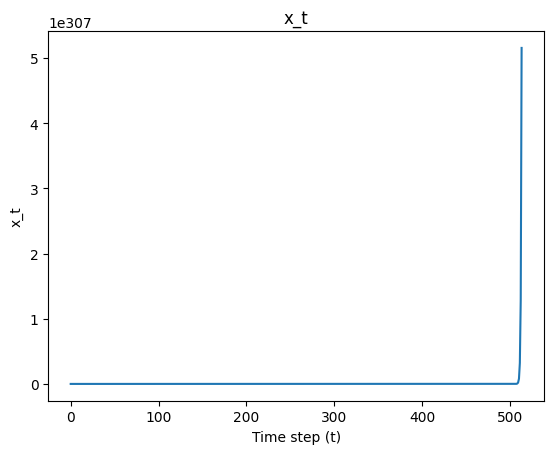

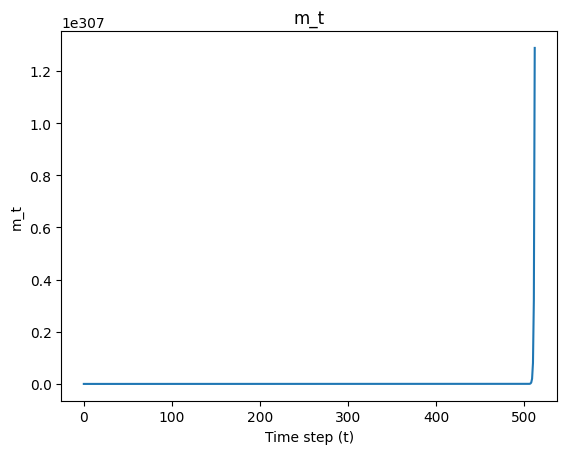

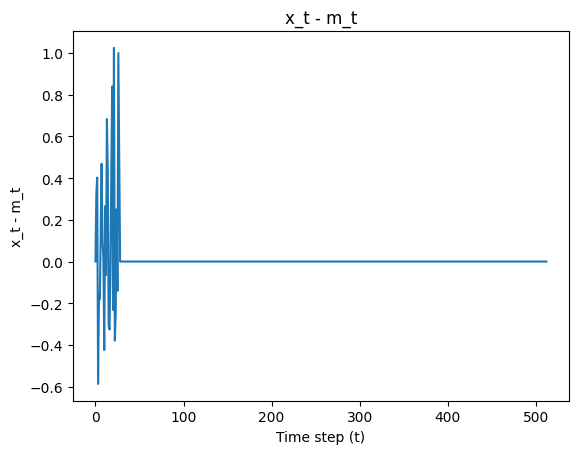

In [143]:
A = np.array([[2, 1, 0, 0], [0, 2, 1, 0], [0, 0, 2, 1], [0, 0, 0, 4]])
C = np.array([[2, 0, 0, 0]])
Q = np.eye(4)  
R = np.array([[1]])
T = 1000 
x = np.zeros((4, T))
y = np.zeros((1, T))
x_hat = np.zeros((4, T))
Sigma = np.zeros((4, 4, T))
x[:, 0] = np.zeros((4,))  
Sigma[:, :, 0] = np.eye(4) 
 
for t in range(T - 1):
    w = np.random.normal(0, 1, (4,))
    v = np.random.normal(0, 1, (1,))
    x[:, t + 1] = A @ x[:, t] + w
    y[:, t + 1] = C @ x[:, t + 1] + v
    x_hat_prior = A @ x_hat[:, t]
    Sigma_prior = A @ Sigma[:, :, t] @ A.T + Q
    K = Sigma_prior @ C.T @ np.linalg.inv(C @ Sigma_prior @ C.T + R)
    x_hat[:, t + 1] = x_hat_prior + K @ (y[:, t + 1] - C @ x_hat_prior)
    Sigma[:, :, t + 1] = (np.eye(4) - K @ C) @ Sigma_prior

plt.figure()
plt.plot(x[0, :])
plt.xlabel('Time step (t)')
plt.ylabel('x_t')
plt.title('x_t')
plt.show()

plt.figure()
plt.plot(x_hat[0, :])
plt.xlabel('Time step (t)')
plt.ylabel('m_t')
plt.title('m_t')
plt.show()

plt.figure()
plt.plot(x[0, :] - x_hat[0, :])
plt.xlabel('Time step (t)')
plt.ylabel('x_t - m_t')
plt.title('x_t - m_t')
plt.show()

### c)

Controllable: True
Observable: True
Convergence difference in the final covariance matrices: [[4.94881913e-14 1.80078175e-13 2.05169215e-13 1.52766688e-13]
 [0.00000000e+00 2.43744580e-10 1.20780896e-09 3.05590220e-09]
 [0.00000000e+00 1.22236088e-09 5.82076609e-09 1.40862539e-08]
 [0.00000000e+00 3.08500603e-09 1.40862539e-08 3.32947820e-08]]


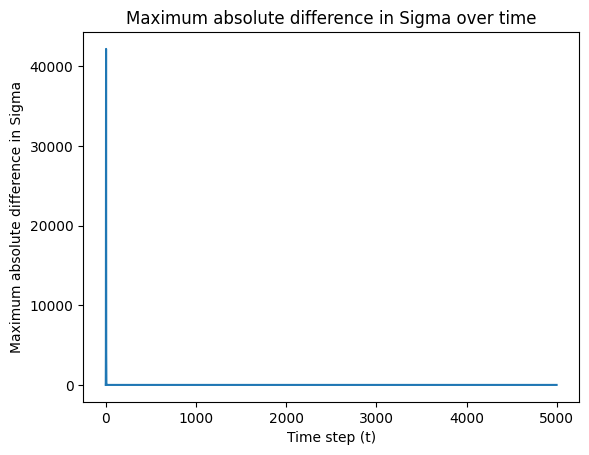

In [144]:
def check_controllability(A, B):
    n = A.shape[0]
    controllability_matrix = np.column_stack([B] + [A @ B])
    for _ in range(2, n):
        controllability_matrix = np.column_stack((controllability_matrix, A @ controllability_matrix[:, -1]))
    return np.linalg.matrix_rank(controllability_matrix) == n

def check_observability(A, C):
    return check_controllability(A.T, C.T)

A = np.array([[2, 1, 0], [0, 2, 1], [0, 0, 2]])
B = np.eye(3)
C = np.array([[4, 0, 0]])
controllable = check_controllability(A, B)
observable = check_observability(A, C)

# Riccati recursions converge to a unique limit under the condition system is both controllable and observable. 
print(f"Controllable: {controllable}")
print(f"Observable: {observable}")

A = np.array([[2, 1, 0, 0], [0, 2, 1, 0], [0, 0, 2, 1], [0, 0, 0, 4]])
C = np.array([[2, 0, 0, 0]])
B = np.eye(4)
Q = np.eye(4) 
R = np.array([[1]]) 
 # simulation
T = 5000
Sigma = np.zeros((4, 4, T))
Sigma[:, :, 0] = np.eye(4)  

def covariance_update(Sigma_prev, A, C, W, V):
    Sigma_prior = A @ Sigma_prev @ A.T + W
    K = Sigma_prior @ C.T @ np.linalg.inv(C @ Sigma_prior @ C.T + V)
    Sigma_next = (np.eye(4) - K @ C) @ Sigma_prior
    return Sigma_next

for t in range(T - 1):
    Sigma[:, :, t + 1] = covariance_update(Sigma[:, :, t], A, C, Q, R)

convergence_diff = np.abs(Sigma[:, :, -1] - Sigma[:, :, -2])
print(f"Convergence difference in the final covariance matrices: {convergence_diff}")

plt.figure()
plt.plot(np.max(np.abs(np.diff(Sigma, axis=2)), axis=(0, 1)))
plt.xlabel('Time step (t)')
plt.ylabel('Maximum absolute difference in Sigma')
plt.title('Maximum absolute difference in Sigma over time')
plt.show()

The graph demonstrates that the greatest absolute variation in Sigma steadily approaches zero, suggesting the Riccati recursions stabilize towards a distinct limit. Furthermore, the minimal value of convergence_diff signals that the ultimate covariance matrices have effectively reached convergence.

This observation leads us to deduce that the Riccati recursions of the specified system indeed settle at a distinct limit, attributable to the system being both controllable and observable.